# CSE 152A Winter 2023 – Homework 4


- Assignment Published On: **Mon, Mar 06, 2023**

- Due On: **Thu, March 16, 2023 11:59 PM (Pacific Time)**

In [ ]:
####################### QUESTION 1 ##################################

# 1. Backpropogation

<img src="q1.png">

## 1(a/b)



```
# This is formatted as code
```

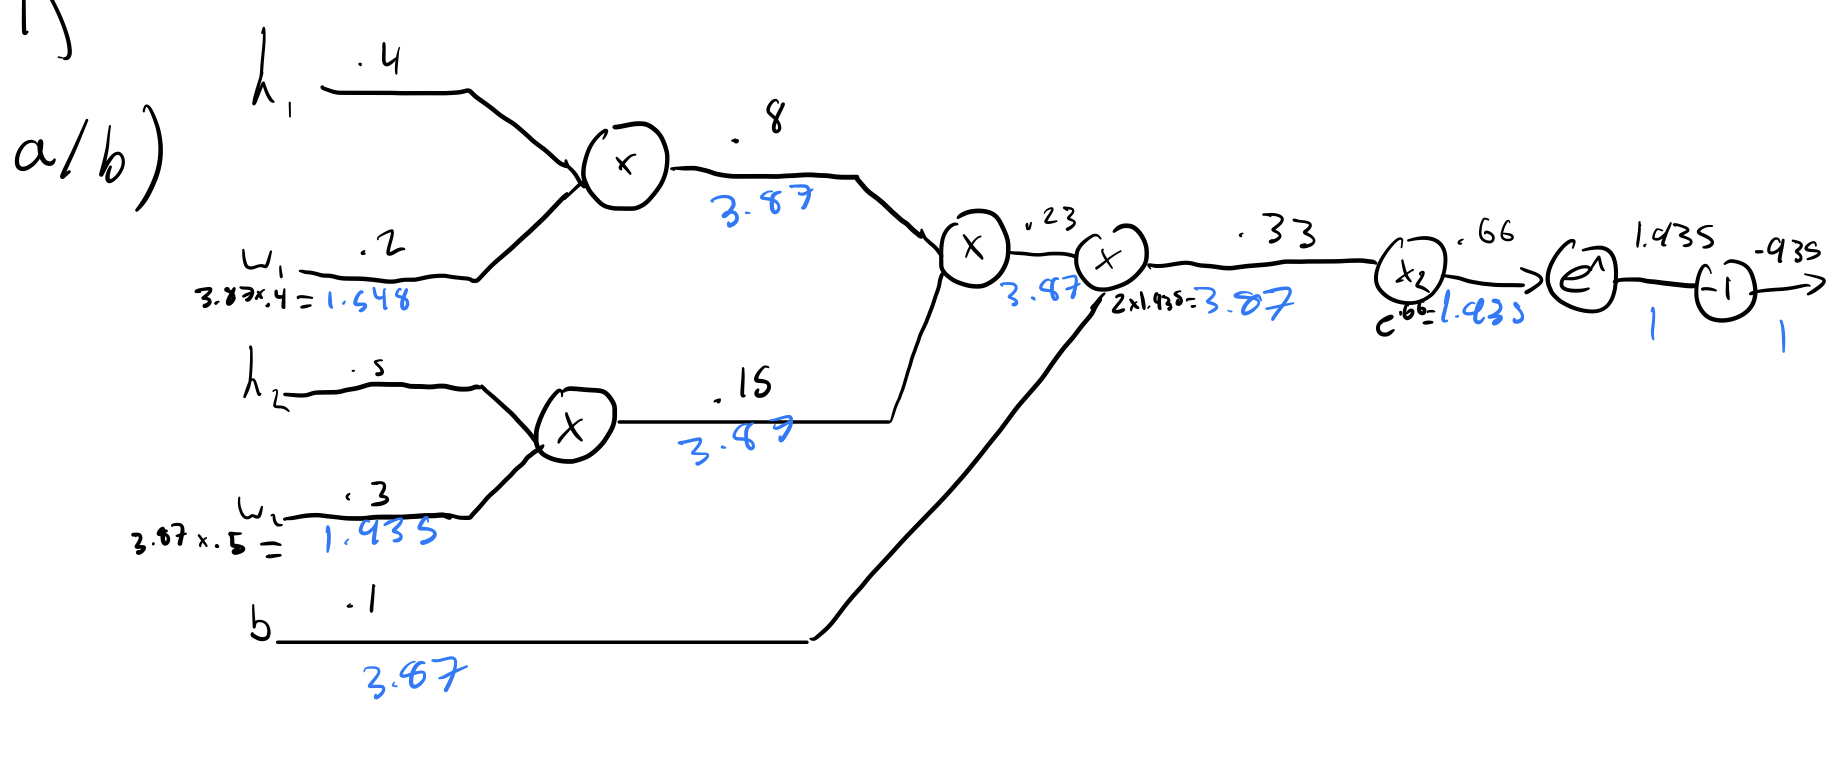

## 1(c)

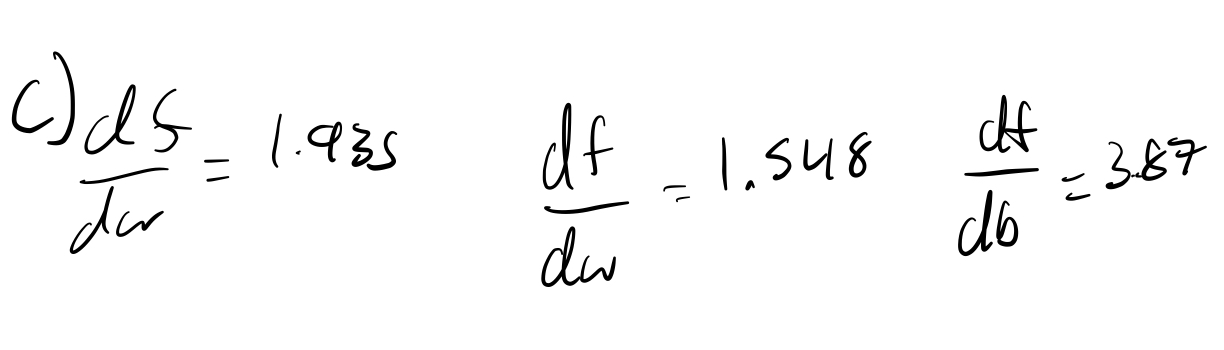

Write your answer here

## 1(d)

The operations of addition and subtraction in a neural network are implemented using a gate that distributes gradients,thus allowing the value to pass through the gate without affecting it by having any changes on it.
In contrast, multiplication is implemented using a gate that switches gradients, multiplying the gradient from the first input by the value from the second input and vice versa.
For exponentiation, specifically in the case of y = a * exp(x), the gradient before the exponentiation gate would be the exponential of the input value to the gate multiplied by the gradient.


Write your answer here

In [ ]:
####################### QUESTION 2 ######################################

#GOOGLE COLAB USERS: If you are using google colab, uncomment the cell below and run it to download the datasets via script
#so that you don't have to upload the data every time you work on it! :)

In [ ]:

!if [ -e "MNIST" ];then rm -rf "MNIST" ; fi
!if [ -e "CIFAR-10" ];then rm -rf "CIFAR-10" ; fi

!mkdir MNIST
%cd MNIST
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gzip -d train-images-idx3-ubyte.gz
!gzip -d train-labels-idx1-ubyte.gz
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz
%cd ..

!mkdir CIFAR-10
%cd CIFAR-10
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz
%cd ..


/content/MNIST
--2023-03-17 01:53:28--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3120::, ...
Connecting to yann.lecun.com (yann.lecun.com)|188.114.97.0|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.04s   

2023-03-17 01:53:28 (237 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2023-03-17 01:53:28--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3120::, ...
Connecting to yann.lecun.com (yann.lecun.com)|188.114.97.0|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[=================

# 2. Training a small CNN for MNIST digit classification

In this problem, you will train a small convolutional neural network for image classification, using PyTorch. We will use the MNIST dataset for digit classification (http://yann.lecun.com/exdb/mnist/)

**You need to have an enviroment with CUDA GPU to finish this homework**. If you don't have access to such environment, a good platform to look at is Google Colab, which provides a free CUDA GPU server.

**You also need to download the CIFAR-10 dataset to complete this homework.** The following cells in Q3 will guide you on downloading them. It requires certain tool to be installed in your environment. You can either use that cell to download the datasets or manually download them on the corresponding website.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import struct
from torch.utils.data import Dataset
import random
import os
import struct
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

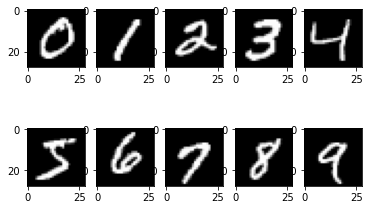

In [ ]:
# DATA PARSING
# If this is running on GPU cluster in the default workspace, no change required
# If running on GPU cluster in created directory, change path as required
# If running on PC download MNIST dataset from http://yann.lecun.com/exdb/mnist/ and set path

path = "./MNIST/" # If on Colab, make sure you can access the MNIST dataset folder.

def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainData=np.float32(np.expand_dims(trainData,-1))/255
torchTrainData=trainData.transpose((0,3,1,2))
trainLabels=np.int32(np.array(list(read('training','labels'))))

testData=np.array(list(read('testing','images')))
testData=np.float32(np.expand_dims(testData,-1))/255
torchTestData=testData.transpose((0,3,1,2))
testLabels=np.int32(np.array(list(read('testing','labels'))))

plt.figure()
for i in range(10):
    ind=np.where(trainLabels==i)[0][0]
    plt.subplot(2,5,i+1)
    plt.imshow(trainData[ind][:,:,0],cmap='gray')
plt.show()

**2(a) [ 3 points ] Define the network structure as follows**

* Convolutional layer with 32 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Convolutional layer with 64 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Fully connected layer with 1024 output channels
* In place ReLU activation layer
* Dropout layer with drop rate 0.4
* Fully connected layer with 10 output channels

In [ ]:
class Net(nn.Module):
    def __init__(self,drop):
        super(Net, self).__init__()
        
        # YOUR CODE HERE
        # DEFINE THE NETWORK STRUCTURE
        self.drop = drop
        self.conv1 = nn.Conv2d(1,32,5,1,2)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32,64,5,1,2)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64,1024)
        self.relu3 = nn.ReLU(inplace=True)
        self.droplayer = nn.Dropout(p=drop)
        self.fc2 = nn.Linear(1024,10)
        # Example: self.conv1 = nn.Conv2d(1, 3, 5,stride=1,padding=2,bias=True)
        # You can look at https://github.com/ameykusurkar/pytorch-image-classifier/blob/master/main.py for reference
        
    def forward(self, x):
        
        # YOUR CODE HERE     
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x) 
        x = self.pool2(x)
        x = x.reshape(-1, 7*7*64)
        x = self.fc1(x)
        x = self.relu3(x)
        #x = self.drop(x)
        if(self.drop == False):
          x = self.droplayer(x)
        x = self.fc2(x)
        # Example: x = self.conv1(x)
        
        return x

# Print net
net = Net(drop=True)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (relu3): ReLU(inplace=True)
  (droplayer): Dropout(p=True, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)


**2(b) [ 5 points ] Complete the train function below. Use the same parameters to perform training in each of the following setups:**
* SGD for optimization, without dropout
* SGD for optimization, with dropout
* Adam for optimization, without dropout
* Adam for optimization, with dropout.

As evaluation for each case above, perform the following:
* Plot the loss graph and the accuracy graph on **training set** on the same plot
* Print the accuracy on **test set** (please use the given `test` function).

Test accuracies are expected to be quite high (~98 %)

In [ ]:
# CODE BELOW IS AN EXAMPLE STARTER
# FEEL FREE TO EDIT ANYTHING

# to_train is a parameter that determines what part of the net to train
# it is not required for this question, but will be useful in the next one
def train(tdata,tlabel,net,to_train,opt,batch,lol):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]
    
    # Change parameters as required
    epochs=15
    #batch=200
    learning_rate=1e-3
    
    if(opt=='adam'):
        optimizer = optim.Adam(to_train,lr=learning_rate)
    else:
        optimizer = optim.SGD(to_train,lr=learning_rate,momentum = lol)
        
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata)/batch)):
            inds=np.random.randint(0,len(tdata)-1,batch)
            
            # inputs and targets for the current iteration
            # NOTE: Do not use targets to compute the loss, instead use tlabel[inds].
            # This is because Variable accumulates gradients.
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            
            
            # YOUR CODE HERE
            # Train the model using the optimizer and the batch data
            # Append the loss and accuracy to the losslist and acclist arrays
            ##########################################
            optimizer.zero_grad()
            temp = net(inputs)
            loss = criterion(temp, targets)
            loss.backward()
            optimizer.step()
            val = np.argmax(temp.cpu().data.numpy(),1)
            accuracy = np.mean((val) == tlabel[inds])
            losslist.append(loss.item())
            acclist.append(accuracy)

    return losslist,acclist

def test(tdata,tlabel,net):
    inputs = Variable(torch.FloatTensor(tdata).cuda())
    targets = Variable(torch.LongTensor(tlabel).cuda())
    prediction = net(inputs)
    acc=np.mean(np.argmax(prediction.data.cpu().numpy(),1)==tlabel)

    return acc

100%|██████████| 15/15 [00:34<00:00,  2.33s/it]


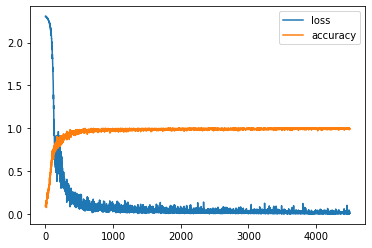

Accuracy:0.9907


100%|██████████| 15/15 [00:34<00:00,  2.27s/it]


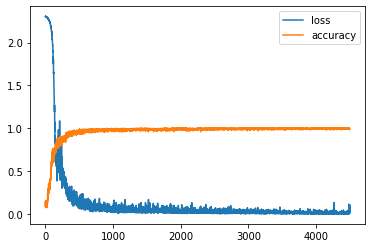

Accuracy:0.9899


100%|██████████| 15/15 [00:37<00:00,  2.50s/it]


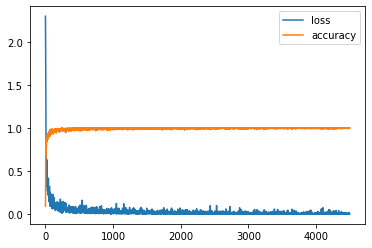

Accuracy:0.9936


100%|██████████| 15/15 [00:37<00:00,  2.47s/it]


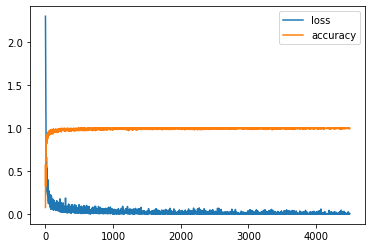

Accuracy:0.9927


In [ ]:
# Example code 
# net = Net(drop=False).cuda()
# loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'sgd')
# ax=range(len(x1))
# plt.plot(ax,loss,ax,acc)
# plt.legend(['loss','accuracy'])
# plt.show()
# print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))

# YOUR CODE HERE
net = Net(drop=False).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'sgd',200,0.99)
ax=range(len(loss))
plt.plot(ax,loss,ax,acc)
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))


net = Net(drop=True).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'sgd',200,0.99)
ax=range(len(loss))
plt.plot(ax,loss,ax,acc)
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))

net = Net(drop=False).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'adam',200,0.99)
ax=range(len(loss))
plt.plot(ax,loss,ax,acc)
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))

net = Net(drop=True).cuda()
loss,acc=train(torchTrainData,trainLabels,net,net.parameters(),'adam',200,0.99)
ax=range(len(loss))
plt.plot(ax,loss,ax,acc)
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(test(torchTestData,testLabels,net)))



**2(c) [ 5 points ] Plot the following graphs and comment on them**

* Training loss graphs of SGD−dropout and Adam−dropout on the same plot 
* Training loss graphs for Adam-dropout for 3 different values of batch size such that there is some difference in the graphs, on the same plot

100%|██████████| 15/15 [00:37<00:00,  2.48s/it]


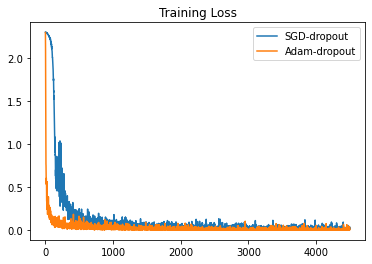

100%|██████████| 15/15 [00:28<00:00,  1.88s/it]


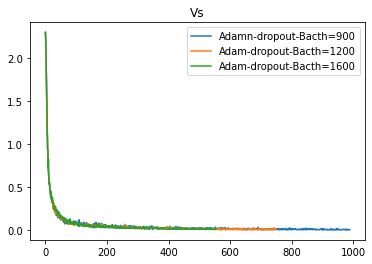

In [75]:
# YOUR CODE HERE
net = Net(drop=True).cuda()
lossSdg,accSdg=train(torchTrainData,trainLabels,net,net.parameters(),'sgd',200,0.99)

net = Net(drop=True).cuda()
lossAdam, accAdam = train(torchTrainData, trainLabels, net, net.parameters(), 'adam',200,0.99)
ax=range(len(loss))

plt.plot(ax,lossSdg, label='SGD-dropout')
plt.plot(ax,lossAdam, label='Adam-dropout')
plt.title('Training Loss')
plt.legend()
plt.show()


net = Net(drop=True).cuda()
lossAdamDiff1, accAdamDiff1 = train(torchTrainData, trainLabels, net, net.parameters(), 'adam',900,0.99)
ax1=range(len(lossAdamDiff1))
net = Net(drop=True).cuda()
lossAdamDiff2, accAdamDiff2 = train(torchTrainData, trainLabels, net, net.parameters(), 'adam',1200,0.99)
ax2=range(len(lossAdamDiff2))
net = Net(drop=True).cuda()
lossAdamDiff3, accAdamDiff3 = train(torchTrainData, trainLabels, net, net.parameters(), 'adam',1600,0.99)
ax3=range(len(lossAdamDiff3))

plt.plot(ax1,lossAdamDiff1, label='Adamn-dropout-Bacth=900')
plt.plot(ax2,lossAdamDiff2, label='Adam-dropout-Bacth=1200')
plt.plot(ax3,lossAdamDiff3, label='Adam-dropout-Bacth=1600')
plt.title('Vs')
plt.legend()
plt.show()


#orange graph was faster to reach the bottom meanwhile blue took longer to reach


#for the vs graph the higher ther batch size the more linear it gets



**2(d) [ 2 points ] Plot the training loss graphs for changes made in any particular parameter (learning rate/momentum etc) such that there is a clear difference in the graphs, on the same plot, and comment.**

In [ ]:
# YOUR CODE HERE
net = Net(drop=True).cuda()
lossAdamDiff1, accAdamDiff1 = train(torchTrainData, trainLabels, net, net.parameters(), 'adam',900,69)
ax1=range(len(lossAdamDiff1))
net = Net(drop=True).cuda()
lossAdamDiff2, accAdamDiff2 = train(torchTrainData, trainLabels, net, net.parameters(), 'adam',1200,0.5)
ax2=range(len(lossAdamDiff2))

plt.plot(ax1,lossAdamDiff1, label='Adamn-dropout-Bacth=900,momentum=69')
plt.plot(ax2,lossAdamDiff2, label='Adam-dropout-Bacth=1200,momentum=.5')
plt.title('Training Loss')
plt.legend()
plt.show()

#the orange graph is more thin than the blue graph and ther blue graph is longer


 60%|██████    | 9/15 [00:17<00:11,  1.97s/it]

In [ ]:
###############################  QUESTION 3  ##############################################

# 3. Transfer learning

You will now visualize the effects of transfer learning by performing experiments using the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html) . Note that this is just to understand how transfer learning works, in practice it is generally used with very large datasets and complex networks

In [ ]:
# DATA PARSING
# If this is running on GPU cluster in the default workspace, no change required
# If running on GPU cluster in created directory, change path as required
# If running on PC download CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and set path

path='./CIFAR-10/cifar-10-batches-py/'

data=np.zeros((0,32,32,3))
labels=[]
for i in range(1,6):
    with open(path+'data_batch_'+str(i), 'rb') as fo:
        dat = pickle.load(fo,encoding='latin1')
        r=dat['data'][:,:1024*1].reshape((10000,32,32,1))
        g=dat['data'][:,1024:2048].reshape((10000,32,32,1))
        b=dat['data'][:,2048:3072].reshape((10000,32,32,1))
        rgb=np.concatenate((r,g,b),axis=3)
        data=np.vstack((data,np.float32(rgb)/255))
        labels+=dat['labels']
labels=np.array(labels)

# data -> 50000 X 32 X 32 X 3 array with training data
# labels -> 50000 labels ranging from 0 to 9



```
`# This is formatted as code`
```

 **3(a) [ 2 points ] Plot 3 random images for each label from the training data**


In [ ]:
# YOUR CODE HERE #
#pick 3 ones and find their indexes us those indexes pick 
idx0 = np.where(labels == 0)[0][:3]
for i in idx0:
  plt.imshow(data[i])
  plt.show()

idx = np.where(labels == 1)[0][:3]
print(idx)
for i in idx:
  plt.imshow(data[i])
  plt.show()
print(labels)

idx1 = np.where(labels == 2)[0][:3]
for i in idx1:
  plt.imshow(data[i])
  plt.show()

idx2 = np.where(labels == 3)[0][:3]
for i in idx2:
  plt.imshow(data[i])
  plt.show()

idx3 = np.where(labels == 4)[0][:3]
for i in idx3:
  plt.imshow(data[i])
  plt.show()

idx4 = np.where(labels == 5)[0][:3]
for i in idx4:
  plt.imshow(data[i])
  plt.show()

idx5 = np.where(labels == 6)[0][:3]
for i in idx5:
  plt.imshow(data[i])
  plt.show()

idx6 = np.where(labels == 7)[0][:3]
for i in idx6:
  plt.imshow(data[i])
  plt.show()

idx7 = np.where(labels == 8)[0][:3]
for i in idx7:
  plt.imshow(data[i])
  plt.show()

idx8 = np.where(labels == 9)[0][:3]
for i in idx8:
  plt.imshow(data[i])
  plt.show()

In [ ]:
# Split the data and labels into 2 sets, first one containing labels 0 to 4, and second one from 5 to 9. 

data1=np.zeros((0,32,32,3))
labels1=[]
data2=np.zeros((0,32,32,3))
labels2=[]
for i in range(5):
    x=data[labels==i]
    data1=np.vstack((data1,x))
    labels1+=[i]*len(x)
for i in range(5,10):
    x=data[labels==i]
    data2=np.vstack((data2,x))
    labels2+=[i-5]*len(x)
    
labels1=np.array(labels1)
labels2=np.array(labels2)

torch_data1=data1.transpose((0,3,1,2))
torch_data2=data2.transpose((0,3,1,2))

**3(b) [ 3 points ] Create a simple convolutional network to classify the training data. The network structure should be as follows:**
1. Layer 1 - Kernel size 4, Stride 2, Output channels 5, Bias enabled, Relu activation
2. Layer 2 - Kernel size 4, Stride 1, Output channels 10, Bias enabled, Relu avtication
3. Layer 3 - Kernel size 4, Stride 1, Output channels 20, Bias enabled, Relu activation
4. Layer 4 - Kernel size 4, Stride 1, Output channels 40, Bias enabled, Relu activation
5. Layer 5 - Fully connected layer with 5 outputs

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # YOUR CODE HERE

        self.conv = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=4, stride=2, bias=True)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=4, stride=1, bias=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=4, stride=1, bias=True)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=4, stride=1, bias=True)
        self.relu3 = nn.ReLU()
        self.fc = nn.Linear(in_features=40*6*6, out_features=5, bias=True)
    
        
    def forward(self, x):
        
        # YOUR CODE HERE
        x = self.conv(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)  
        x = self.conv3(x)
        x = self.relu3(x)
        x = x.reshape(-1, 40*6*6)
        x = self.fc(x)
        return x
    
net = Net()
print(net)

**3(c) [ 5 points ] Complete the train function below and follow the instructions** 

* Initialize the network, train the complete network (net.parameters) on data1 (The first 5 classes)
* Plot the loss and accuracy graphs over training on the same plot
* Print the final training accuracy as well**

Set the learning rate, number of iterations and batch size such that the loss is gradually and smoothly decreasing and converging. The accuracy at the end of training must be around or greater than 60 %.

In [97]:
# to_train can be net.paramaters OR net.fc.parameters OR net.conv1.parameters so that only certain parts of the net are trained
def train(tdata,tlabel,net,to_train):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]
    
    # Change as required
    epochs=5
    batch=100
    learning_rate=1e-3
    optimizer = optim.Adam(to_train,lr=learning_rate)
    
    for k in tqdm(range(epochs)):
        for l in range(int(len(tdata)/batch)):
            inds=np.random.randint(0,len(tdata)-1,batch)
            inputs = Variable(torch.FloatTensor(tdata[inds]).cuda())
            targets = Variable(torch.LongTensor(tlabel[inds]).cuda())
            
            # YOUR CODE HERE
            optimizer.zero_grad()
            temp = net(inputs)
            loss = criterion(temp, targets)
            loss.backward()
            optimizer.step()
            x = loss.item()
            losslist.append(x)
            dummy, var = torch.max(temp.data, 1)
            acc1 = ((var == targets).sum().item()) / (targets.size(0))
            acclist.append(acc1)


    return losslist,acclist

100%|██████████| 5/5 [00:08<00:00,  1.64s/it]


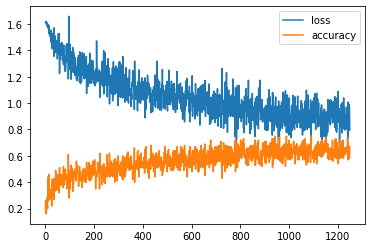

Accuracy:0.69


In [98]:

# YOUR CODE HERE #
net = Net().cuda()
losslist, acclist = train(torch_data1,labels1,net,net.parameters())
ax=range(len(losslist))
plt.plot(ax,losslist,ax,acclist)
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[len(acc)-1]))
# Plot the loss and accuracy graphs

**3(d) [ 2 points ] Without reinitializing the network, train only the fully connected layer (net.fc.parameters) now on data2 (The next 5 classes)** 

Do not change any hyper parameters such as learning rate or batch size. Plot the loss and accuracy and print the final values like before.

100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


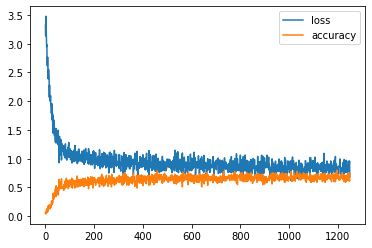

Accuracy:0.75


In [99]:
# YOUR CODE HERE #
loss,acc=train(torch_data2,labels2,net,net.fc.parameters())
ax=range(len(loss))
plt.plot(ax,loss,ax,acc)
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[len(acc)-1]))

**3(e) [ 3 points ] Now repeat the process in the opposite order** 

* Initialize the net again, train the whole network on data2, generate the same plots as before
* Then without reinitializing the net, train only the fully connected layer on data1 and generate the plots

Do not change any hyperparameters.

100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


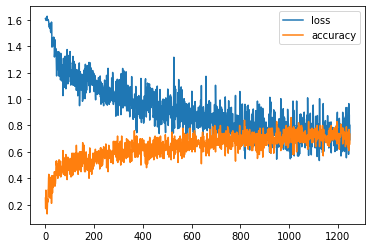

Accuracy:0.66


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


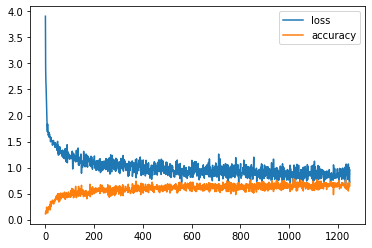

Accuracy:0.65


In [100]:
# YOUR CODE HERE #
net = Net().cuda()
loss,acc=train(torch_data2,labels2,net,net.parameters())
ax=range(len(loss))
plt.plot(ax,loss,ax,acc)
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[len(acc)-1]))

loss,acc=train(torch_data1,labels1,net,net.parameters())
ax=range(len(loss))
plt.plot(ax,loss,ax,acc)
plt.legend(['loss','accuracy'])
plt.show()
print('Accuracy:{}'.format(acc[len(acc)-1]))

**3(f) [ 5 points ]**

* Plot the loss vs iterations for the classifers trained to classify data1, via normal learning as well as transfer learning, on the same plot
* Plot another graph for the classifiers trained to classify data2

Explain the results obtained, based on the training regimen. Comment on why transfer learning worked/didn't work.

100%|██████████| 5/5 [00:04<00:00,  1.08it/s]


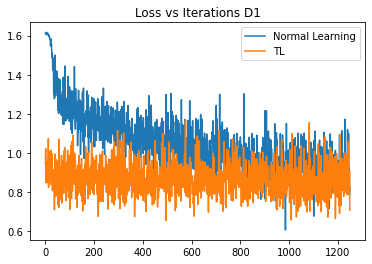

Accuracy:0.65


100%|██████████| 5/5 [00:04<00:00,  1.15it/s]


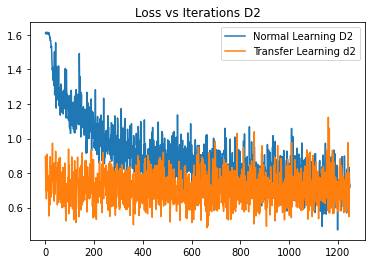

Accuracy for Data2: 0.7


In [104]:
# YOUR CODE HERE #

net = Net().cuda()
nl, na = train(torch_data1, labels1, net, net.parameters())

tl, ta = train(torch_data1, labels1, net, net.fc.parameters())

# Plot the loss vs iterations for data 1
fig, ax = plt.subplots()
t = range(len(nl))
ax.plot(t, nl, label='Normal Learning')
t1 = range(len(tl))
ax.plot(t1, tl, label='TL')
ax.set_title('Loss vs Iterations D1')
ax.legend()
plt.show()
print('Accuracy:{}'.format(acc[len(acc)-1]))

net3 = Net().cuda()
nl2, na2 = train(torch_data2, labels2, net3, net3.parameters())

tl2, ta2 = train(torch_data2, labels2, net3, net3.fc.parameters())

# Plot the loss vs iterations for data2
fig, ax = plt.subplots()
y = range(len(tl2))
ax.plot(y, nl2, label='Normal Learning D2')
ax.plot(y, tl2, label='Transfer Learning d2')

ax.set_title('Loss vs Iterations D2')
ax.legend()
plt.show()
print('Accuracy for Data2: {}'.format(ta2[len(ta2)-1]))

#for the first graph below the orange color is more linear compared to the blue

#for the seconds graph we can see that the blue graph has a more steeper slop than the first graph above

**[UNGRADED]** <br/>
Create a network with more layers, pooling layers, and more filters and try to increase accuracy as much as possible. Play around with the hyperparameters to understand how they affect the training process. No need to turn in anything for this. Here are some ideas to explore and play around with if you are interested:

*   Initialization
    *   Random (default)
    *   Xavier
    *   Glorot
*   Activation functions
    *   Sigmoid
    *   ReLU
    *   ELU
    *   SELU
    *   Leaky ReLU
    *   GELU
    *   Mish
*   Optimizer
    *   SGD
    *   RMSProp
    *   AdaGrad
    *   AdaDelta
    *   Adam
    *   CLR [\[Paper\]](https://arxiv.org/abs/1506.01186)
*   Convolutions
    *   5x5 colvolutions
    *   3x3 convolutions
    *   1x1 convolutions (either with a stride or used in tandem with 3x3 or 5x5 conv)
*   Pooling layers
    *   Max Pooling
    *   Average Pooling
*   Normalization
    *   Batchnormalization \[[PyTorch Docs](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)\]
    *   Instance normalization \[[PyTorch Docs](https://pytorch.org/docs/stable/generated/torch.nn.InstanceNorm2d.html#torch.nn.InstanceNorm2d)\]
*   Regularization
    *   Dropout (Using different percentages)
    *   Alpha Dropout \[[PyTorch Docs](https://pytorch.org/docs/stable/generated/torch.nn.AlphaDropout.html#torch.nn.AlphaDropout)\] (Try using this with SELU activation and batchnorm)